In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv("../data library/Soja_v1.csv", sep=";")
df = df.sort_values(by="Data")
df = df.reset_index(drop=True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [23]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])
#df2.set_index('Data', inplace = True)
#df2.dropna(inplace=True)
#df2 = df2.asfreq('ME', method = 'bfill') 
df2 = df2[["Data","Estadual"]]


df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int(len(df2)*0.8))].copy()
test_df = df2[(int(len(df2)*0.8)):].copy()

In [24]:
training_data = train_df.copy()
testing_data = test_df.copy()

In [25]:
training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["Estadual"]

In [27]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=2, test_size=len(X_test))
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=50),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [29]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  _, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

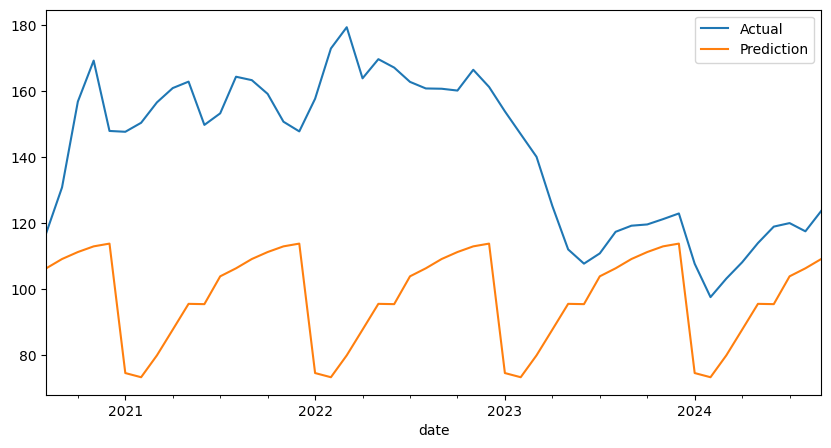

MAE: 44.10129410766601
RMSE: 51.33452317207814
MAPE: 0.2935026994358033


In [30]:

# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)